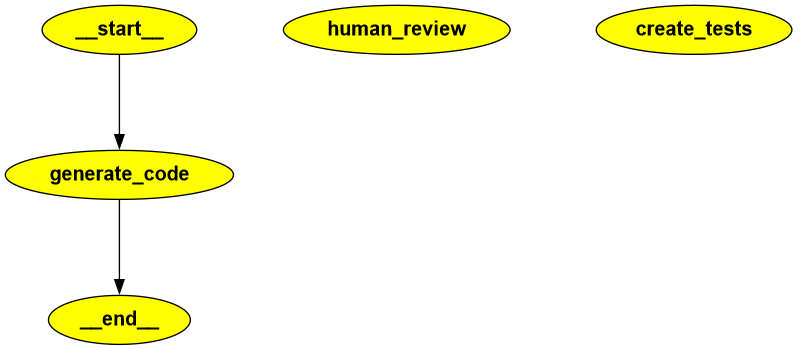

Generate Code

-----Generated Code--------
Here is a sample Python code to create a function to reverse a string:

```python
def reverse_string(input_string):
    return input_string[::-1]

# Test the function
input_str = "Hello, World!"
reversed_str = reverse_string(input_str)
print("Original string:", input_str)
print("Reversed string:", reversed_str)
```

You can use this `reverse_string` function to reverse any string you pass as an argument to it.
(PregelTask(id='6b9bca05-6176-c6f3-04c4-0fb05f3b2a36', name='human_review', path=('__pregel_pull', 'human_review'), error=None, interrupts=(Interrupt(value={'question': 'Are you ok with the code.Type yes or no'}, resumable=True, ns=['human_review:6b9bca05-6176-c6f3-04c4-0fb05f3b2a36']),), state=None, result=None),)


Are you ok with the code.Type yes or no yes



--- Generated Tests ---
```python
import unittest

def reverse_string(input_string):
    return input_string[::-1]

class TestReverseString(unittest.TestCase):

    def test_reverse_string(self):
        input_str = "Hello, World!"
        expected_output = "!dlroW ,olleH"
        self.assertEqual(reverse_string(input_str), expected_output)

    def test_reverse_string_empty(self):
        input_str = ""
        expected_output = ""
        self.assertEqual(reverse_string(input_str), expected_output)

    def test_reverse_string_numbers(self):
        input_str = "12345"
        expected_output = "54321"
        self.assertEqual(reverse_string(input_str), expected_output)

if __name__ == '__main__':
    unittest.main()
```


In [3]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.types import interrupt
from langgraph.types import Command
from IPython.display import Image, display


from dotenv import load_dotenv
load_dotenv()

"""
1. Chuẩn bị và định nghĩa State
State cho workflow gồm:
- task: Yêu cầu coding (vd: “Viết hàm đảo ngược chuỗi…”)
- code: Kết quả code sinh ra
- tests: Kết quả test/unit test cho đoạn code t
"""
class CodingAssistantState(TypedDict):
    task: str
    code: str
    tests: str

"""
2. Khởi tạo các chain và model
- code_chain: Prompt → LLM → Parse chuỗi, để sinh code từ task
- test_chain: Prompt → LLM → Parse chuỗi, để sinh test/unit test từ code
"""
model = ChatOpenAI()

code_prompt = ChatPromptTemplate.from_template("Generate Python code for: {task}")
test_prompt = ChatPromptTemplate.from_template("Write unit tests for this code:\n{code}")

code_chain = code_prompt | model | StrOutputParser()
test_chain = test_prompt | model | StrOutputParser()

"""
3.  Định nghĩa các node (function) cho workflow
a. generate_code
Nhận state (có task), sinh code với LLM, update state với key "code", chuyển sang node "human_review".
b. human_review (Human-in-the-loop)
- Đây là node đặc biệt:
    + Dùng interrupt() để tạm dừng pipeline, gửi câu hỏi về cho con người phê duyệt (“Are you ok with the code. Type yes or no”).
    + Kết quả return sẽ là một “interrupt object” → pipeline dừng chờ input từ người dùng.
    + Khi user trả lời "yes" → tiếp tục sang node "create_tests", ngược lại kết thúc (END).
- Điều này tạo ra đúng tính năng Human-in-the-loop: AI sinh code, con người quyết định có tiếp tục hay không.
c. create_tests
- Nhận code, sinh test/unit test, lưu lại vào state và kết thúc workflow.
"""
def generate_code(state):
    print("Generate Code")
    code = code_chain.invoke({"task": state["task"]})
    return Command(goto="human_review", update={"code": code})



def human_review(state):
    value = interrupt({
        "question": "Are you ok with the code.Type yes or no"
    })
    if value == "yes":
        return Command(goto="create_tests")
    else:
        return Command(goto=END)


def create_tests(state):
    tests = test_chain.invoke({"code": state["code"]})
    return Command(goto=END, update={"tests": tests})

"""
4. Xây dựng workflow graph
- 3 node chính: generate_code → human_review → create_tests → END
- Entry point là "generate_code"
- Sử dụng MemorySaver để lưu lại toàn bộ tiến trình và trạng thái (phục vụ resume sau interrupt, multi-turn workflow).
"""
def create_coding_assistant_workflow():
    workflow = StateGraph(CodingAssistantState)
    workflow.add_node("generate_code", generate_code)
    workflow.add_node("human_review", human_review)
    workflow.add_node("create_tests", create_tests)
    workflow.set_entry_point("generate_code")
    return workflow.compile(checkpointer=MemorySaver())


# Run the Workflow
coding_assistant = create_coding_assistant_workflow()

# Draw grpah
try:
    display(Image(coding_assistant.get_graph().draw_png()))
except Exception as e:
    print(e)
#
"""
5. Run workflow và handle Human-in-the-loop
"""
inputs = {"task": "Create a function to reverse a string in Python."}
thread = {"configurable": {"thread_id": 1}}
result = coding_assistant.invoke(inputs, config=thread)
# TODO: Handle Interrupt
print("\n-----Generated Code--------")
print(result["code"])
tasks = coding_assistant.get_state(config=thread).tasks
print(tasks)
task = tasks[0]
question = task.interrupts[0].value.get("question")
user_input = input(question)
result = coding_assistant.invoke(Command(resume=user_input),config=thread)

print("\n--- Generated Tests ---")
print(result.get("tests", "No code or tests generated"))





## Quy trình làm việc chi tiết: AI Coding Assistant (Human-in-the-loop)

### 1. Người dùng nhập yêu cầu (task)
- Ví dụ:  
  `"Create a function to reverse a string in Python."`
- Input này được truyền vào workflow tại bước đầu tiên.



### 2. Node 1: `generate_code` — AI sinh code Python
- Nhận state:
  ```python
  {"task": "Create a function to reverse a string in Python."}

* Prompt gửi tới LLM:

  ```
  "Generate Python code for: Create a function to reverse a string in Python."
  ```
* LLM (ChatOpenAI) trả về đoạn code Python phù hợp.
* Kết quả code được lưu vào state:

  ```python
  {"task": "...", "code": "def reverse_string(s): ..."}
  ```
* **Workflow chuyển sang node `"human_review"`**.



### 3. Node 2: `human_review` — Con người phê duyệt (Human-in-the-loop)

* Nhận state (có code AI vừa sinh ra).
* Gọi `interrupt()` với câu hỏi:

  > "Are you ok with the code. Type yes or no"
* **Workflow tạm dừng** và chờ input từ người dùng (human).
* **Người dùng xem code, trả lời "yes" hoặc "no".**

---

### 4. Xử lý trả lời của con người

* Nếu **user trả lời `"yes"`**:

  * Workflow chuyển sang node `"create_tests"`.
* Nếu **user trả lời `"no"`**:

  * Workflow kết thúc (`END`), không sinh test.

---

### 5. Node 3: `create_tests` — Sinh unit tests tự động (nếu user đồng ý)

* Nhận code từ state.
* Prompt gửi tới LLM:

  ```
  "Write unit tests for this code:\n<code>"
  ```
* LLM sinh ra test/unit test cho đoạn code trên.
* Cập nhật state với trường `"tests"`.
* Workflow kết thúc.

---

### 6. Kết quả cuối cùng

* Nếu user đồng ý ("yes"): bạn nhận được **code** và **unit tests**.
* Nếu user không đồng ý ("no"): workflow dừng sau bước duyệt code.

---

**Tóm lại:**
Quy trình này giúp tích hợp hoàn hảo giữa AI tự động và quyết định của con người, đảm bảo mọi code đều được phê duyệt trước khi sinh test, phù hợp cho các ứng dụng lập trình an toàn, kiểm duyệt code, hoặc đào tạo lập trình.

```


